## 📌 Agenda

1. **Setups**  
2. **Models** → Talk directly with the model  
3. **Graphs** → Learn graph structure through mini examples *(Graph I–V)*
4. **LangGraph concepts** → human in the loop (HITL) and time travel
5. **ChatBot** → Build a practical chatbot enriched with tools  
6. **Podcast Generator** → Use search to gather information, apply planning & critique, and generate a podcast on your chosen subject  



### 🚀 Let’s get started!


## ▶️ Using Jupyter Notebooks

- Press **`Ctrl+Enter`** to run the selected cell.  
- Alternatively, hover over a code cell and click the **▶️ play button** on the right.  
- Each code cell shows an execution counter on the left:  
  - `In [ ]:` → the cell has **not run yet**  
  - `In [5]:` → the cell has **already run** (5th in order)  
  - `In [*]:` → the cell is **currently running**  
- When code is running, you’ll also see a **sand-watch (⏳)** or “busy” indicator in the notebook tab or toolbar.  

- To make it interactive, every time you see **`None`** you are expected to replace it with the required values.  
  If you’re not sure, don’t worry . every exercise has an **Answer Key** that is hidden in a collapsible block.  
  Click **“Answer key (click to expand)”** under the code snippet to reveal the solution. 

In [ ]:
%pip install -q \
    langgraph \
    langchain \
    langchain-openai \
    langchain-community \
    langchain-tavily \
    tavily-python \
    azure-cognitiveservices-speech \
    wikipedia \
    imageio-ffmpeg \
    ipython \
    requests==2.32.4


## ⚙️ LLM Setup

This section configures all the API keys, endpoints, and deployment names as environment variables.
These settings allow our LangGraph agents to securely access all the resources

First, let’s initialize our connection to the Azure OpenAI endpoint using environment variables.

In [12]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    deployment_name=os.environ["OPENAI_DEPLOYMENT_NAME"],  
    openai_api_version=os.environ["OPENAI_API_VERSION"],
    azure_endpoint=os.environ["OPENAI_API_ENDPOINT"],
    openai_api_key=os.environ["OPENAI_API_KEY"],
    temperature=0.3
)

Now we can test our model by calling it with a simple prompt.   
Enter a question you would like to ask the model.

In [ ]:
response = llm.invoke("None")
print(response)

The response we receive from the model includes both the **actual content** (the model’s answer) and **extra metadata** (such as token usage, request IDs, and safety checks).  
👉 If you only want the explicit answer, use the **`content`** field of the response.


In [ ]:
print(response.content)

## 🖼️ Image Generation

Now that we’ve set up our LLM, it’s time to configure **image generation**.  
In this notebook, we’ll be using **OpenAI’s DALL·E 3** through the Azure OpenAI service.  

We’ll create a helper function that takes a **text prompt** and generates an image using the **DALL·E model**.


In [69]:
from openai import AzureOpenAI
import json


def create_image(prompt: str) -> str:
    client = AzureOpenAI(
        api_version=os.getenv("DALLE_API_VERSION"),
        azure_endpoint=os.getenv("DALLE_API_ENDPOINT"),
        api_key=os.getenv("DALLE_API_KEY"),
    )

    result = client.images.generate(
        model=os.getenv("DALLE_DEPLOYMENT_NAME"), prompt=prompt, n=1
    )

    image_url = json.loads(result.model_dump_json())["data"][0]["url"]

    return image_url

Fill in the prompt with the description of the image you want to generate

In [ ]:
prompt = "None"

image_url = create_image(prompt)

print(image_url)

## 🕸️ Graphs

In this section, we’ll explore the fundamentals of **LangGraph** by building small, hands-on examples.  
You’ll learn how **nodes**, **edges**, **state**, and **execution paths** work together to form a graph.  

These simple graphs will help you build the intuition needed before moving on to more advanced agent workflows.


##### **Graph 1**

We’re building a very simple LangGraph state graph that consists of a single node. This graph takes a user’s name, passes it through the greeter node, and outputs a friendly greeting message. It’s a minimal example to demonstrate how state flows through a LangGraph application.

In [130]:
from langgraph.graph import StateGraph, START, END
import random
from typing import Dict, List, TypedDict
from IPython.display import Image, display

Lets Define the state schema. 
A state schema in LangGraph defines the structure and types of the data shared between nodes as the graph runs.

In [131]:
# Here, the state has only one key: message. a string that will be modified as it moves through nodes.

class WorkflowState(TypedDict): # Our state schema
    message : str


Node logic:

In [132]:
def greeting_node(state: WorkflowState) -> WorkflowState:
    """Simple node that adds a greeting message to the state"""

    state["message"] = f"Hello {state['message']}, how are you?"

    # Returns the updated state to be passed along in the graph.
    return state

Build the graph (insert in the ):

In [ ]:
# Creates a new state graph with our schema.
# Replace None with the state schema class we defined above
graph = StateGraph(None) 

# Add the greeter node.
# First "None" → choose the the node's name as a string 
# Second None → the function that should run in the node
graph.add_node("None", None) 

# Define the entry point.
# Replace None with the name of the node that should run first
graph.set_entry_point("None") 

# Define the finish point.
# Replace None with the name of the node that should end the flow 
graph.set_finish_point("None") 

<details>
  <summary><b>Answer key (click to expand)</b></summary>

```python
# Creates a new state graph with our schema.
# Replace None with the state schema class we defined above
graph = StateGraph(WorkflowState) 

# Add the greeter node.
# First "None" → choose the node's name as a string 
# Second None → the function that should run in the node
graph.add_node("greeter", greeting_node) 

# Define the entry point.
# Replace None with the name of the node that should run first
graph.set_entry_point("greeter") 

# Define the finish point.
# Replace None with the name of the node that should end the flow 
graph.set_finish_point("greeter")  


##### **compile()**
Compiling is a pretty simple step. It provides a few basic checks on the structure of your graph (no orphaned nodes, etc).  
It is also where you can specify runtime args like checkpointer. You compile your graph by just calling the .compile()  
You MUST compile your graph before you can use it.  

Lets compile the graph.

In [134]:
app = graph.compile()

Now lets see how the graph looks like:  

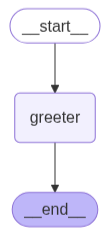

run the graph:

👉 Insert your name instead of **`None`** in the code below:

In [92]:
result = app.invoke({"message": "None"})

<details>
  <summary><b>Answer key (click to expand)</b></summary>

```python
# Example: Replace None with your name as a string
result = app.invoke({"message": "Eliran"})


In [ ]:
result.get("message")

##### **Graph 2**

This graph is a simple two-step sequential workflow.  
It first greets a person by name, then appends their age to the message, producing a final combined string.  
This demonstrates how state flows through multiple nodes, with each node building on the output of the previous one.


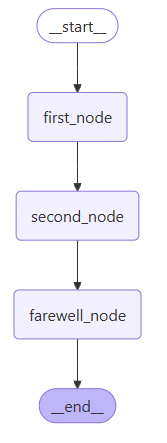

In [125]:
class WorkflowState(TypedDict):
    name: str
    age: int
    final: str

In [126]:
# First node: greeting
def first_node(state: WorkflowState) -> WorkflowState:
    """Greets the user by name."""
    # Replace None with the correct string template
    state["final"] = f"Hi {state[None]}!"   # Hint: use the state's name
    return state

# Second node: append age
def second_node(state: WorkflowState) -> WorkflowState:
    """Appends the user's age to the message."""
    # Replace None with the correct keys
    state["final"] = f"{state[None]} You are {state[None]} years old!"  
    return state

# Third node: farewell
def farewell_node(state: WorkflowState) -> WorkflowState:
    """Adds a farewell message."""
    # Replace None with the right key
    state["final"] = f"{state[None]} Have a great day!"  
    # Hint: continue from the existing final message
    return state


<details>
  <summary><b>Answer key (click to expand)</b></summary>

```python
# First node: greeting
def first_node(state: WorkflowState) -> WorkflowState:
    """Greets the user by name."""
    state["final"] = f"Hi {state['name']}!"
    return state

# Second node: append age
def second_node(state: WorkflowState) -> WorkflowState:
    """Appends the user's age to the message."""
    state["final"] = f"{state['final']} You are {state['age']} years old!"
    return state

# Third node: farewell
def farewell_node(state: WorkflowState) -> WorkflowState:
    """Adds a farewell message."""
    state["final"] = f"{state['final']} Have a great day!"
    return state


In [127]:
# Build the graph
graph = StateGraph(WorkflowState)

# Add the nodes
# First "None" → name of the node (string)
# Second None → the function that should run in that node
graph.add_node("None", None)  
graph.add_node("None", None)  
graph.add_node("None", None)  

# Define entry point
# Replace None with the name of the first node
graph.set_entry_point("None")  

# Add edges between nodes
# Replace both "None" values with the correct source and destination node names
graph.add_edge("None", "None")   # sequential flow
graph.add_edge("None", "None")  

# Define finish point
# Replace None with the name of the last node
graph.set_finish_point("None")  

# Compile the app
app = graph.compile()


<details>
  <summary><b>Answer key (click to expand)</b></summary>

```python
# Build the graph
graph = StateGraph(WorkflowState)

# Add the nodes
graph.add_node("first_node", first_node)  
graph.add_node("second_node", second_node)  
graph.add_node("farewell_node", farewell_node)  

# Define entry point
graph.set_entry_point("first_node")  

# Add edges between nodes
graph.add_edge("first_node", "second_node")   # sequential flow
graph.add_edge("second_node", "farewell_node")  

# Define finish point
graph.set_finish_point("farewell_node")  

# Compile the app
app = graph.compile()


👉 Insert a name and age instead of None in the code below:

In [ ]:
result = app.invoke({"name": "None", "age": None})
print(result.get("final", ""))

##### **Graph 3**

This graph demonstrates **conditional routing** in LangGraph.  
Instead of following a fixed sequence of nodes, the flow dynamically chooses between two calculation nodes: addition or subtraction based on the `operation` field in the state.  

It’s a minimal example of **branching logic** in a state graph.


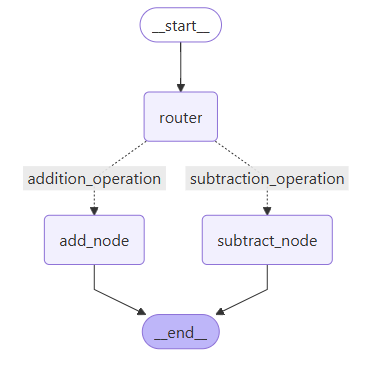

In [142]:
# Define the workflow state
class WorkflowState(TypedDict):
    number1: None        # Hint: should hold the first number
    operation: None      # Hint: should hold the operation symbol ("+" or "-")
    number2: None        # Hint: should hold the second number
    finalNumber: None    # Hint: should hold the result after calculation


<details>
  <summary><b>Answer key (click to expand)</b></summary>

```python
# Define the workflow state
class WorkflowState(TypedDict):
    number1: int        # first number
    operation: str      # operation symbol ("+" or "-")
    number2: int        # second number
    finalNumber: int    # result after calculation


In [138]:
def adder(state:WorkflowState) -> WorkflowState:
    """This node adds the 2 numbers"""
    state["finalNumber"] = state["number1"] + state["number2"]

    return state

def subtractor(state:WorkflowState) -> WorkflowState:
    """This node subtracts the 2 numbers"""
    state["finalNumber"] = state["number1"] - state["number2"]
    return state

#router function that doesn’t change the state. it returns the name of the conditional edge to follow next.
def decide_next_node(state:WorkflowState) -> WorkflowState:
    """This node will select the next node of the graph"""

    if state["operation"] == "+":
        return "addition_operation"

    elif state["operation"] == "-":
        return "subtraction_operation"

In [139]:
graph = StateGraph(WorkflowState)

graph.add_node("add_node", adder)
graph.add_node("subtract_node", subtractor)
graph.add_node("router", lambda state:state) # passthrough function

graph.add_edge(START, "router")

# Defines dynamic branching from the router node
graph.add_conditional_edges(
    "router", # Source node
    decide_next_node, # picks which mapping key to follow

    {
        # Edge: Node => Mapping values are the actual node names to execute next
        # Replace None with the correct node name
        "addition_operation": "None",
        "subtraction_operation": "None"
    }

)

graph.add_edge("add_node", END)
graph.add_edge("subtract_node", END)

app = graph.compile()

<details>
  <summary><b>Answer key (click to expand)</b></summary>

```python
# Defines dynamic branching from the router node
graph.add_conditional_edges(
    "router",          # Source node
    decide_next_node,  # picks which mapping key to follow

    {
        "addition_operation": "add_node",        # goes to the addition node
        "subtraction_operation": "subtract_node" # goes to the subtraction node
    }
)


👉 Replace each None with two numbers of your choice and an operation symbol (+ or -).

In [ ]:
result = app.invoke({"number1": None, "operation": "None", "number2": None})
print(result.get("finalNumber", "no result"))

<details>
  <summary><b>Answer key (click to expand)</b></summary>

```python
# Example: add 5 + 3
result = app.invoke({"number1": 5, "operation": "+", "number2": 3})
print(result.get("finalNumber", "no result"))


##### Graph 4

This graph demonstrates **looping** in LangGraph.  
It repeatedly generates random numbers until a stopping condition is met,  
illustrating how **conditional edges** can be used to create iterative flows within a state graph.


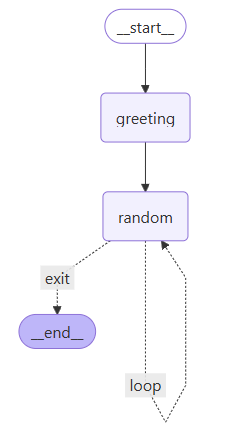

In [160]:
class WorkflowState(TypedDict):
    name: str
    numbersHistory: List[int]
    counter: int

In [161]:
def greeting_node(state: WorkflowState) -> WorkflowState:
    """Greeting Node which says hi to the person"""
    state["name"] = f"Hi there, {state['name']}"
    state["counter"] = 0

    return state

def random_node(state: WorkflowState) -> WorkflowState:
    """Generates a random number from 0 to 10"""
    state["numbersHistory"].append(random.randint(0, 10))
    state["counter"] += 1

    return state


def should_continue(state: WorkflowState) -> str:
    """Function to decide what to do next"""
    if state["counter"] < 5:
        print("ENTERING LOOP", state["counter"])
        return "loop"  # Continue looping
    else:
        return "exit"  # Exit the loop

In [162]:
graph = StateGraph(WorkflowState)

graph.add_node("greeting", greeting_node)
graph.add_node("random", random_node)

graph.set_entry_point("greeting")
graph.add_edge("greeting", "random")

graph.add_conditional_edges(
    "random",     # Source node
    should_continue, # Action
    {
        "loop": "random", # loops back to random when "loop" is returned
        "exit": END
    }
)

app = graph.compile()

👉 Insert a name instead of None in the code below:

app.invoke({"name":"None", "numbersHistory":[], "counter":-100})

## 👤 Human-in-the-Loop

To **review, edit, and approve** tool calls in an agent or workflow, LangGraph supports **interrupts** - special pause points where execution stops and waits for human input.  

- **Interrupts (dynamic breakpoints):**  
  Triggered based on the current state of the graph.  
  You can call `interrupt(...)` in a node to pause execution.  
  The graph then resumes with the user’s input.  

💡 This is useful for tasks like approvals, edits, or gathering extra context.  


#### What we’re about to build

**Flow:** `draft → review (pause with interrupt) → finalize`

1. The model writes a short draft.  
2. The graph **pauses** and asks the user to approve or edit.  
3. If approved → return the draft.  
4. If edited → revise via the model, then return.  

This is the **core pattern** behind approvals, edits, and human checkpoints in agentic systems.


In [169]:
# --- imports ---
from typing import TypedDict
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, SystemMessage

In [170]:
# --- graph state ---
class State(TypedDict, total=False):
    subject: str
    draft: str
    final: str
    human_feedback: str


Lets define the graph nodes:

In [171]:
# --- draft node ---
def draft_node(state: State) -> State:
    subject = (state.get("subject") or "").strip()
    if not subject:
        return {"draft": "⚠️ No subject provided."}

    sys = SystemMessage(
        "You are a concise, factual assistant. Write a brief answer (1–3 sentences) "
        "directly addressing the subject. Prefer concrete facts and plain language. "
        "If information is uncertain or missing, say you’re unsure—do not invent details. "
        "Return only the answer text (no preambles or formatting)."
    )
     
    # Replace None with the correct variable
    user = HumanMessage(None)  
    # Replace None with the messages to send into the LLM
    draft = llm.invoke([None, None]).content
    # Replace None with the variable holding the model output
    return {"draft": None}


<details>
  <summary><b>Answer key (click to expand)</b></summary>

```python
# Replace None with the correct variable
user = HumanMessage(subject)  

# Replace None with the messages to send into the LLM
draft = llm.invoke([sys, user]).content  

# Replace None with the variable holding the model output
return {"draft": draft}


The review node triggers a pause with interrupt(...).  
LangGraph stops here and returns control to the notebook so we can ask a human to approve or edit.

In [172]:
# --- review node (HITL pause) ---
def review_node(state: State) -> State:
    draft = (state.get("draft") or "").strip()
    feddback = interrupt({
        "draft": draft,
        "instructions": "Type YES to approve, or provide edits."
    })

    # When the graph is resumed with Command(resume=...), that value is assigned to feddback
    return {"human_feedback": feddback}


The finalize node returns the draft as-is if the human typed “YES”.
Otherwise, it revises using the human’s edits via the LLM.

In [173]:
def finalize_node(state: State) -> State:
    # Normalize inputs and guard against missing keys
    subject = (state.get("None") or "").strip()
    draft   = (state.get("None") or "").strip()
    fb      = (state.get("None") or "").strip()

    # Treat empty input or common approvals as "approve"
    approved = (fb == "") or fb.lower().startswith(("y", "yes"))

    if approved:
        return {"final": draft}

    sys = SystemMessage(
        "Revise the draft based on the edits. "
        "Keep it short (1–3 sentences), clear, and factual. "
        "Do not make up information. "
        "Return only the revised answer text."
    )

    # Human message with clear delimiters to separate fields
    user = HumanMessage(
        "Please revise the draft using the edits below.\n\n"
        f"Subject:\n```text\n{subject}\n```\n\n"
        f"Draft:\n```text\n{draft}\n```\n\n"
        f"Edits:\n```text\n{fb}\n```\n\n"
        "Revised answer:"
    )

    out = llm.invoke([sys, user])
    return {"final": out.content.strip()}


<details>
  <summary><b>Answer key (click to expand)</b></summary>

```python
subject = (state.get("subject") or "").strip()
draft   = (state.get("draft") or "").strip()
fb      = (state.get("human_feedback") or "").strip()


In [174]:
g = StateGraph(State)

g.add_node("draft", draft_node)
g.add_node("review", review_node)
g.add_node("finalize", finalize_node)

# --- wire with START/END ---
g.add_edge(START, "draft")       # entry point
g.add_edge("draft", "review")
g.add_edge("review", "finalize")
g.add_edge("finalize", END)      # finish point

graph = g.compile(checkpointer=MemorySaver())


In [175]:
subject = "None"   # <-- your subject here

<details>
  <summary><b>Answer key (click to expand)</b></summary>

```python
subject = "how many cats are in israel?"   # <-- your subject here


We invoke the graph with a subject.
If the output contains __interrupt__, the graph is paused. We display the draft & instructions, collect human feedback , then resume.

In [ ]:
import uuid
config = {"configurable": {"thread_id": f"hitl-{uuid.uuid4()}"}}

out = graph.invoke({"subject": subject}, config=config)

if "__interrupt__" in out:
    print(">>> PAUSED — waiting for human input")
    intr = out["__interrupt__"][0]
    print("== REVIEW DRAFT ==")
    print(intr.value["draft"])
    print(intr.value["instructions"])

    human = input("\nApprove or edit: ")
    out = graph.invoke(Command(resume=human), config=config)

print("\n== FINAL ANSWER ==")
print(out.get("final", out))


## ⏳ Time Travel in LangGraph

LangGraph supports **time travel**, which lets you rewind to a past checkpoint, modify state if needed, and resume execution from there.

**Steps:**

1. **Run the graph**  
   Start with your initial inputs using `invoke(...)` or `stream(...)`.

2. **Locate a checkpoint**  
   - Use `get_state_history(thread_id)` to list execution history and find the desired `checkpoint_id`.  
   - Or, set an `interrupt(...)` before a node where you want execution to pause; you can then use the latest checkpoint created up to that point.

3. **(Optional) Update state**  
   Modify the graph’s state at that checkpoint using `update_state(...)`.

4. **Resume from checkpoint**  
   Call `invoke(None, config={...})` or `stream(None, config={...})` with the correct `thread_id` and `checkpoint_id` to continue execution from that point.


In [185]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver 

class State(TypedDict, total=False):
    topic: str
    joke: str

def generate_topic(state: State) -> State:
    sys = SystemMessage("You generate short, concrete topics for jokes. Respond with only a single word or short phrase")
    user = HumanMessage("Pick a random topic for a joke. Be creative and change it every time.")
    return {"topic": llm.invoke([sys, user]).content.strip()}

def write_joke(state: State) -> State:
    # Replace None with a suitable system prompt 
    sys = SystemMessage("None")
    user = HumanMessage(f"Topic: {state['topic']}")
    return {"joke": llm.invoke([sys, user]).content.strip()}

# Build
g = StateGraph(State)

g.add_node("generate_topic", generate_topic)
g.add_node("write_joke", write_joke)
g.add_edge(START, "generate_topic")
g.add_edge("generate_topic", "write_joke")
g.add_edge("write_joke", END)

graph = g.compile(checkpointer=MemorySaver())

<details>
  <summary><b>Answer key (click to expand)</b></summary>

```python
sys = SystemMessage(
    "You are a stand-up comedian performing for a mixed audience. "
    "Always write a short, clever joke about the given topic. "
    "Avoid offensive content."
)


In [ ]:
# 1) First run
import uuid
config = {"configurable": {"thread_id": f"hitl-{uuid.uuid4()}"}}
state1 = graph.invoke({}, config)
print("First topic:", state1["topic"])
print("First joke:", state1["joke"], "\n")

In [ ]:
# 2) Inspect history and pick the checkpoint right before write_joke
states = list(graph.get_state_history(config))  # newest first
snap_before_write = next(s for s in states if "write_joke" in s.next)
print("Resuming from checkpoint:", snap_before_write.config["configurable"]["checkpoint_id"])

In [188]:
# 3) Time-travel: change the topic at that checkpoint (branch state)
topic = "None" # <--- insert a topic 
new_config = graph.update_state(snap_before_write.config, values={"topic": topic})

In [ ]:
# 4) Resume from that checkpoint; only write_joke runs again
state2 = graph.invoke({}, new_config)
print("Branched topic:", state2["topic"])
print("Branched joke:", state2["joke"])

#### 🤖 ChatBot

In this section, we’ll start building a chatbot step by step:

1. **Basic Chatbot** – The chatbot will first communicate directly with the LLM, responding to user input in a simple conversation loop.  
2. **Agentic Chatbot with Tools** – Next, we’ll enrich the chatbot by giving it access to external tools.  
   This effectively turns it into an *agent* that can decide when to call a tool (e.g., web search, image generation).


In [196]:
import os
import json
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
from langchain_core.tools import tool
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import create_openai_functions_agent, AgentExecutor
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
import warnings
warnings.simplefilter("ignore", ResourceWarning)
from langchain_openai import AzureChatOpenAI
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from openai import AzureOpenAI
from langchain_tavily import TavilySearch

In [197]:
class State(TypedDict):
    # merges state by appending new messages instead of overwriting the list.
    messages: Annotated[list, add_messages]

Lets define the chatbot node, which takes user prompt (with the history),
sends it to the LLM, and returns the assistant’s reply.

In [198]:
def chatbot(state: State):
    msgs = state["messages"]
    return {"messages": [llm.invoke(msgs)]}

In [199]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile(checkpointer=MemorySaver())

In [202]:
import uuid
def get_content(msg):
    return msg.content if isinstance(msg, BaseMessage) else msg.get("content", "")

# An interactive session that takes user input, sends it to the graph, 
# streams back the assistant’s latest message from the output, and prints it to the terminal.
def run_chat_loop(app):
    print("Type 'quit' to exit.\n")
    config = {"configurable": {"thread_id": f"hitl-{uuid.uuid4()}"}}

    while True:
        user = input("User: ")
        if user.strip().lower() in {"quit", "exit", "q"}:
            print("Goodbye!")
            break

        # Send ONLY the new HumanMessage; the rest of the history is in the checkpoint
        result = app.invoke({"messages": [HumanMessage(content=user)]}, config=config)

        # The latest assistant message is the last in state["messages"]
        last = result["messages"][-1]
        print("Assistant:", last.content)

In [ ]:
run_chat_loop(graph)

Now lets upgrade the simple LLM chatbot into an agent that can call tools. one for fresh web search and one for image generation.  
so it can pull up-to-date info and create images on demand.

Lets make the create image we declared before into a tool our chatbot agent could use

In [204]:
# tells the agent it must provide a prompt string
class CreateImageInput(BaseModel):
    prompt: str = Field(..., description="Text describing the image to generate.")

# '@tool' registers the function so the agent can call it when an image request is detected.
@tool("create_image_tool", args_schema=None)
def create_image_tool(prompt: str) -> str:
    """Generate an image using Azure OpenAI Images (DALL·E) and return a URL."""
    try:
        return create_image(prompt)
    except Exception as e:
        return f"Image generation failed: {e}"

<details>
  <summary><b>Answer key (click to expand)</b></summary>

```python
@tool("create_image", args_schema=CreateImageInput)


Let’s add a search tool so the agent can perform real-time web lookups.
We’ll use TavilySearch, a LangChain community tool that wraps the Tavily API for seamless, up-to-date results.

In [205]:
search_tool = TavilySearch(tavily_api_key=os.environ["TAVILY_API_KEY"])

In [206]:
# list of all the tools you want the agent to have
tools = [None, None]

<details>
  <summary><b>Answer key (click to expand)</b></summary>

```python
# list of all the tools you want the agent to have
tools = [search_tool, create_image_tool]


Lets create the chatbot agent:

In [207]:
# Defines the agent’s prompt
chatbot_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a helpful AI assistant. "
     "Use search tool for fresh/accurate web info. "
     "When the user asks to generate/draw/design an image, call the `create_image` tool. "
     "Be concise and factual. Do not dump raw search results."),
    MessagesPlaceholder("chat_history"),
    ("user", "{input}"),
    MessagesPlaceholder("agent_scratchpad"),
])

# Create the agent and wrap it in an AgentExecutor that handles tool calls and returns the final output.
chatbot_agent = create_openai_functions_agent(llm=llm, tools=tools, prompt=chatbot_prompt)
chatbot_executor = AgentExecutor(agent=chatbot_agent, tools=tools, verbose=False)

In [208]:
def get_content(msg):
    return msg.content if isinstance(msg, BaseMessage) else msg.get("content", "")

def chatbot_node(state: State):
    last = state["messages"][-1]
    query = get_content(last)

    history = state["messages"][:-1]
    result = chatbot_executor.invoke({
        "input": query,
        "chat_history": history,  
    })

    # Let the reducer append; return ONLY the new message
    return {"messages": [AIMessage(content=result["output"])]}

In [ ]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile(checkpointer=MemorySaver())

In [ ]:
run_chat_loop(graph)

## 🎙️ Podcast Generator Agent

In this section, we are going to build a LangGraph-powered multi-step agentic workflow that automatically generates and produces a podcast episode end-to-end.

🔑 What it does

- Starts from a user-provided topic.

- Creates a high-level outline of the podcast.

- Iteratively performs research using multiple tools (Wikipedia, Tavily).

- Writes a draft podcast script, citing credible sources.

- Runs a critique + revision loop to refine the script.

- Converts the final script into speech with Azure TTS, alternating between two voices.

- Merges audio files into a complete MP3 podcast episode.

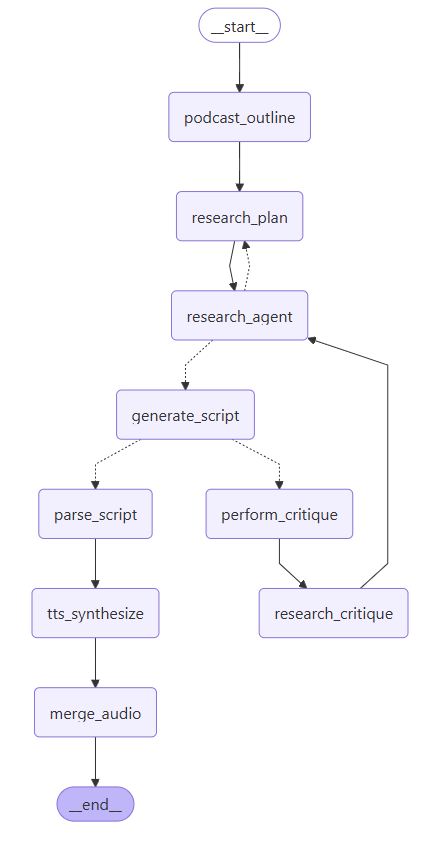

In [19]:
# choose the topic for your podcast
PODCAST_TOPIC = "None"  # <---------- choose a topic 

In [16]:
# --- Imports ---
import os
import re
import time
import uuid
import subprocess
import imageio_ffmpeg
from typing import TypedDict

from IPython.display import Audio, display, Markdown

from langchain_openai import AzureChatOpenAI
from langchain.schema.document import Document
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool

from langchain_tavily import TavilySearch
from langchain_community.retrievers import WikipediaRetriever

from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import create_tool_calling_agent, AgentExecutor

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph

import azure.cognitiveservices.speech as speechsdk


# ========================== Memory ==========================
memory = MemorySaver()

# ========================== State ==========================
class AgentState(TypedDict):
    revision_number: int
    max_revisions: int
    search_count: int
    max_searches: int
    task: str
    outline: str
    queries: list
    content: list
    draft: str
    critique: str
    tool_calls: list
    parsed_script: list
    audio_parts: list
    audio_path: str

# ========================== Tools ==========================
search_tool = TavilySearch(tavily_api_key=os.environ["TAVILY_API_KEY"])

@tool
def search_online(query: str) -> list[Document]:
    """Search for information online using Tavily."""
    docs = search_tool.invoke(query)
    return docs or ["No results found online"]

@tool
def search_wikipedia(query: str) -> list[Document]:
    """Search for information on Wikipedia."""
    retriever = WikipediaRetriever()
    docs = retriever.invoke(query)
    return docs or ["No results found on Wikipedia"]

RESEARCH_TOOLS = [search_online, search_wikipedia]

# ========================== Prompts ==========================
OUTLINE_PROMPT = """You are an expert writer tasked with writing a high level outline of an engaging 2-minute podcast.
Write such an outline for the user provided topic. Give an outline of the podcast along with any
relevant notes or instructions for the sections."""

RESEARCH_PLAN_PROMPT = """You are a researcher tasked with providing information that can
be used when writing the following podcast. Generate one search query consisting of a few
keywords that will be used to gather any relevant information. Do not output any information
other than the query consisting of a few words.

These were the past queries, do not repeat keywords from past queries in your newly generated query:
---
{queries}"""

WRITER_PROMPT = """
You are a writing assistant tasked with writing engaging 2-minute podcast scripts.

- Generate the best podcast script possible for the user's request and the initial outline.
- The script MUST strictly alternate lines between the two hosts, separating each host's line with a newline.
- Add an intro phrase and outro phrase to start and end the podcast, and use a fun, random name for the podcast show.
- Given a critique, respond with a revised version of your previous script.
- Include lively back-and-forth chatter, reflections, and expressions of amazement between the hosts.
- Cite at least THREE pieces of research throughout the script, choosing the most relevant research for each point.
- DO NOT include ANY of the following:
    - Speaker labels (e.g., "Host 1:", "Host 2:")
    - Sound effect descriptions (e.g., "[Sound of waves]")
    - Formatting instructions (e.g., "(Emphasis)", "[Music fades in]")
    - Any other non-dialogue text.
- Use this format for citations, including the month and year if available:
    "In [Month, Year], [Organization] found that..."
    "Research from [Organization] in [Month, Year] showed that..."
    "Back in [Month, Year], a study by [Organization] suggested that..."
---
Utilize all of the following search results and context as needed:
{content}
---
If this is a revision, the critique will be provided below:
{critique}"""

CRITIQUE_PROMPT = """You are a producer grading a podcast script.
Generate critique and recommendations for the user's submission.
Provide detailed recommendations, including requests for conciseness, depth, style, etc."""

RESEARCH_CRITIQUE_PROMPT = """You are a writing assistant tasked with providing information that can
be used when making any requested revisions (as outlined below).
Generate one search query consisting of a few keywords that will be used to gather any relevant
information. Do not output any information other than the query consisting of a few words.

These were the past queries, so you can vary the query that you generate:
---
{queries}
"""


RESEARCH_AGENT_PROMPT = ChatPromptTemplate.from_messages([
    ("system",
     "You are a focused research assistant. Given a topic or search query, "
     "pick the best tool(s), gather a few high-quality sources, and produce a concise evidence summary. "
     "Prefer diverse sources. If one tool fails, try another. Stop when you have enough."),
    ("user", "{query}"),
    MessagesPlaceholder("agent_scratchpad"),
])


research_agent = create_tool_calling_agent(
    llm=llm,
    tools=RESEARCH_TOOLS,
    prompt=RESEARCH_AGENT_PROMPT,
)

research_executor = AgentExecutor(
    agent=research_agent,
    tools=RESEARCH_TOOLS,
    verbose=False,         # set True if you want to see tool traces
    max_iterations=3,
    handle_parsing_errors=True,
)

# ========================== Nodes ==========================
def podcast_outline_node(state: AgentState):
    messages = [SystemMessage(content=OUTLINE_PROMPT), HumanMessage(content=state["task"])]
    response = llm.invoke(messages)
    return {"outline": response.content}

def research_plan_node(state: AgentState):
    messages = [
        SystemMessage(content=RESEARCH_PLAN_PROMPT.format(queries=state.get("queries", []))),
        HumanMessage(content=state["task"]),
    ]
    response = llm.invoke(messages)
    prev = state.get("queries", [])
    return {"queries": prev + [response.content]}

def research_agent_node(state: AgentState):
    # Use the latest planned query
    query = (state.get("queries") or [""])[-1]

    # Run the agent loop (model ↔ tools ↔ observations)
    result = research_executor.invoke({"query": query})
    final_summary = result["output"]
    steps = result.get("intermediate_steps", [])  # [(AgentAction, observation), ...]

    # Keep newest content first
    new_content = [final_summary] + (state.get("content") or [])

    # Lightweight log of tool calls (optional)
    tool_log = state.get("tool_calls") or []
    for action, observation in steps:
        tool_log.append({
            "tool": getattr(action, "tool", ""),
            "input": getattr(action, "tool_input", ""),
            "observation": str(observation)[:800],
        })

    return {
        "content": new_content,
        "tool_calls": tool_log,
        "search_count": state["search_count"] + 1,
    }

def should_continue_tools(state: AgentState):
    # Continue planning/research until search_count > max_searches
    return "generate_script" if state["search_count"] > state["max_searches"] else "research_plan"

def generate_script_node(state: AgentState):
    messages = [
        SystemMessage(content=WRITER_PROMPT.format(
            content=state["content"],
            critique=state.get("critique", "")
        )),
        HumanMessage(content=f"{state['task']}\n\nHere is my outline:\n\n{state['outline']}"),
    ]
    response = llm.invoke(messages)
    return {
        "draft": response.content,
        "search_count": 0,
        "revision_number": state.get("revision_number", 1) + 1
    }

def perform_critique_node(state: AgentState):
    messages = [SystemMessage(content=CRITIQUE_PROMPT), HumanMessage(content=state["draft"])]
    response = llm.invoke(messages)
    return {"critique": response.content}

def research_critique_node(state: AgentState):
    # Keep the original approach: produce another query from the critique
    messages = [
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT.format(queries=state.get("queries", []))),
        HumanMessage(content=state["critique"]),
    ]
    response = llm.invoke(messages)
    prev = state.get("queries", [])
    return {"queries": prev + [response.content]}

def should_continue(state: AgentState):
    # When revisions exceed max_revisions, proceed to TTS
    return "parse_script" if state["revision_number"] > state["max_revisions"] else "perform_critique"

def parse_script_node(state: AgentState):
    draft = state.get("draft", "")
    return {"parsed_script": to_lines(draft) if draft else []}

def tts_synthesize_node(state: AgentState):
    # Azure TTS (needs AZURE_TTS_KEY and AZURE_TTS_REGION)
    speech_config = speechsdk.SpeechConfig(
        subscription=os.environ["AZURE_TTS_KEY"],
        region=os.environ["AZURE_TTS_REGION"]
    )
    voice_options = ["en-US-AriaNeural", "en-US-GuyNeural"]

    os.makedirs("tts_parts", exist_ok=True)
    audio_files = []

    parsed = state.get("parsed_script", []) or []
    for idx, line in enumerate(parsed):
        if not line.strip():
            continue
        speech_config.speech_synthesis_voice_name = voice_options[idx % 2]
        filename = f"tts_parts/part-{idx}.wav"
        audio_config = speechsdk.audio.AudioOutputConfig(filename=filename)
        synthesizer = speechsdk.SpeechSynthesizer(speech_config=speech_config, audio_config=audio_config)
        result = synthesizer.speak_text_async(line).get()
        if result.reason == speechsdk.ResultReason.SynthesizingAudioCompleted:
            audio_files.append(filename)

    return {"audio_parts": audio_files}

def merge_audio_node(state: AgentState):
    parts = state.get("audio_parts", []) or []
    if not parts:
        return {"audio_path": ""}

    ffmpeg_exe = imageio_ffmpeg.get_ffmpeg_exe()
    if not ffmpeg_exe:
        raise RuntimeError("Could not find or install ffmpeg")

    filelist_path = "tts_parts/filelist.txt"
    with open(filelist_path, "w", encoding="utf-8") as f:
        for p in parts:
            abs_path = os.path.abspath(p).replace("\\", "/")
            f.write(f"file '{abs_path}'\n")

    output_path = "azure-podcast.mp3"
    cmd = [
        ffmpeg_exe, "-y",
        "-f", "concat", "-safe", "0",
        "-i", filelist_path,
        "-c:a", "libmp3lame", "-b:a", "192k",
        output_path
    ]
    result = subprocess.run(cmd, capture_output=True, text=True)

    # best-effort cleanup
    try:
        for p in parts:
            try:
                os.remove(p)
            except PermissionError:
                time.sleep(0.5)
                try:
                    os.remove(p)
                except Exception:
                    pass
        os.remove(filelist_path)
    except Exception:
        pass

    if result.returncode != 0:
        return {"audio_path": f"ffmpeg failed: {result.stderr[:300]}"}

    return {"audio_path": output_path}

# ========================== Helpers ==========================
def clean_agent_result(data):
    s = str(data)
    s = re.sub(r"[^\x00-\x7F]+", " ", s)
    s = re.sub(r"\\\\n", "\n", s)
    s = re.sub(r"\\n", "", s)
    s = re.sub(r"\\'", "'", s)
    return s

def to_lines(draft: str):
    lines = [ln.strip() for ln in draft.replace("\r\n", "\n").split("\n") if ln.strip()]
    lines = [re.sub(r'^[\-\*\u2022\d\.\)\s]+', '', ln) for ln in lines]
    return lines

# ========================== Graph ==========================
workflow = StateGraph(AgentState)

workflow.add_node("podcast_outline", podcast_outline_node)
workflow.add_node("research_plan", research_plan_node)
workflow.add_node("research_agent", research_agent_node)
workflow.add_node("generate_script", generate_script_node)
workflow.add_node("perform_critique", perform_critique_node)
workflow.add_node("research_critique", research_critique_node)
workflow.add_node("parse_script", parse_script_node)
workflow.add_node("tts_synthesize", tts_synthesize_node)
workflow.add_node("merge_audio", merge_audio_node)

workflow.set_entry_point("podcast_outline")

# fixed edges
workflow.add_edge("podcast_outline", "research_plan")
workflow.add_edge("research_plan", "research_agent")
workflow.add_edge("perform_critique", "research_critique")
workflow.add_edge("research_critique", "research_agent")

# conditional edges
workflow.add_conditional_edges(
    "research_agent",
    should_continue_tools,
    {"generate_script": "generate_script", "research_plan": "research_plan"},
)
workflow.add_conditional_edges(
    "generate_script",
    should_continue,
    {"perform_critique": "perform_critique", "parse_script": "parse_script"},
)

# TTS path
workflow.add_edge("parse_script", "tts_synthesize")
workflow.add_edge("tts_synthesize", "merge_audio")
workflow.add_edge("merge_audio", END)

graph = workflow.compile(checkpointer=memory)

In [ ]:
import uuid

config = {"configurable": {"thread_id": f"hitl-{uuid.uuid4()}"}}

initial_state = {
    "task": PODCAST_TOPIC,
    "revision_number": 1,
    "max_revisions": 2,
    "search_count": 0,
    "max_searches": 1,
    "content": [],
    "queries": [],
    "tool_calls": [],
    "parsed_script": [],
    "audio_parts": [],
    "audio_path": "",
}

for state in graph.stream(initial_state, config):
    for k, v in state.items():
        print(f"Agent Node: {k}\n")
        # show a human-friendly snippet
        display(Markdown(clean_agent_result(v)[:1000]))

        # auto-play when we hit the merged MP3
        if k == "merge_audio":
            if isinstance(v, dict) and v.get("audio_path", "").endswith(".mp3"):
                display(Audio(v["audio_path"]))
    print("\n====================\n")
# ==============================================================================================